<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/50_Lite_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Макс 10 баллов

1. Сделайте выделение следующих классов по отдельности:

Пола

Того, что за окном

Людей

Батарей

Лампочек
 

2. Сделайте свою собственную архитектуру и запустите, оцените точность на проверочной выборке.

3. Проверьте различные batch_size.

4. Проверьте различные активационные функции.

5. Напишите свои выводы.

# Подключение бибилиотек


In [ ]:
!ln -sf /opt/bin/invidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize

In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn't guaranteed
# Далее код cработает если переключить Colab на GPU !!!
gpu = GPUs[0] # здесь ошибка?
process = psutil.Process(os.getpid())
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)


Gen RAM Free: 24.7 GB  | Proc size: 95.9 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB
GPU Model:  Tesla T4


In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Сегментация стройки

## Загрузка картинок



In [ ]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height = 240 # Высота уменьшенной картинки 
# num_classes = 7 # Задаем количество классов на изображении
num_classes = 5 # !Изменено
directory = '/content/drive/MyDrive/Базы/Сегментация/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'Тренировочная_стройка' # Название папки с файлами обучающей выборки
val_directory = 'Проверочная_стройка' # Название папки с файлами проверочной выборки

### Оригинальные изображения



In [ ]:
train_images = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути     
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_images)) # Отображаем количество элементов в обучающей выборке

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути                  
    val_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_images)) # Отображаем количество элементов в проверочной выборке

Обучающая выборка загржуена. Время загрузки: 15.68c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 0.62c
Количество изображений:  50


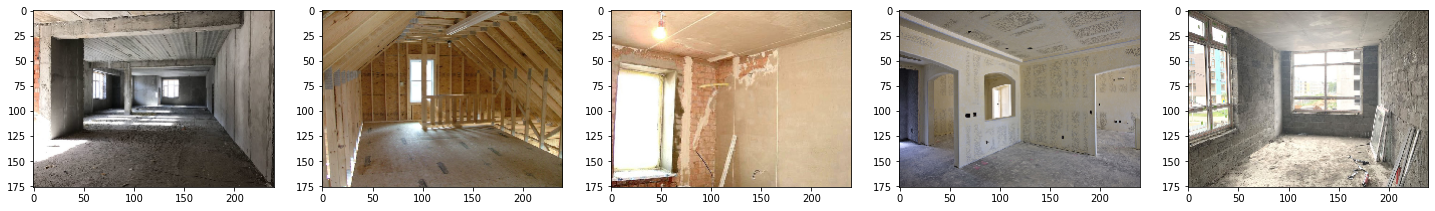

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
    img = random.choice(train_images) # Выбираем случайное фото для отображения
    axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

### Сегментированные изображения

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загржуена. Время загрузки: 14.08c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 0.59c
Количество изображений:  50


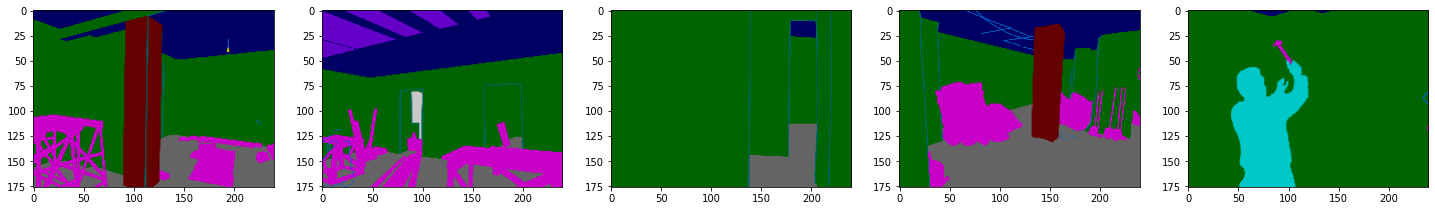

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
    img = random.choice(train_segments) # Выбираем случайное фото для отображения
    axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

## Создание выборки



In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (5 классов) !Изменено
def color2index(color):
    index=-1
    if   (149>=color[0]>51)   and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=0 # пол
    # elif (49>=color[0]>=0)    and (49>=color[1]>=0)    and (149>=color[2]>=51)  : index=1 # потолок !Изменено
    # elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=2 # стена !Изменено
    # elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=4 # колонна !Изменено
    # elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=3 # проем !Изменено
    # elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (149>=color[2]>=51)  : index=3 # дверь !Изменено
    # elif (149>=color[0]>=51)  and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=3 # окно !Изменено
    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (249>=color[2]>=151) : index=1 # внешний мир
    # elif (49>=color[0]>=0)    and (49>=color[1]>=51)   and (249>=color[2]>=151) : index=4 # лестница !Изменено
    # elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=4 # перила !Изменено
    elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=1 # батарея
    elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (249>=color[2]>=151) : index=2 # люди
    # elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=4 # инвентарь !Изменено
    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=1 # источники света
    # elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (249>=color[2]>=151) : index=4 # провода
    # elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=4 # балка
    # else: index=6 
    else: index=3 #! Изменено
    return index  

In [ ]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
    index = np.argmax(index2) # Получаем индекс максимального элемента
    color=[]
    if   index == 0: color = [100, 100, 100]  # пол
    # elif index == 1: color = [0, 0, 100]      # потолок !Изменено
    # elif index == 2: color = [0, 100, 0]      # стена !Изменено
    # elif index == 3: color = [100, 0, 0]      # проем, дверь, окно !Изменено
    elif index == 1: color = [0, 100, 100]    # колонна, лестница, внешний мир, перила, батарея, инвентарь, источники света, провода, балка
    elif index == 2: color = [100, 0, 100]    # люди
    elif index == 3: color = [0, 0, 0]        # остальное
    return color # Возвращаем цвет пикслея

In [ ]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
    y_shape = y.shape # Запоминаем форму массива для решейпа
    y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
    yt = [] # Создаем пустой лист
    for i in range(len(y)): # Проходим по всем трем канала изображения
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
    yt = np.array(yt) # Преобразуем в numpy
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Решейпим к исходныму размеру
    return yt # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
    yTrain = [] # Создаем пустой список под карты сегметации
    for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
        y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
        y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
        yTrain.append(y) # Добавляем очередной элемент в yTrain
        if len(yTrain) % 100 == 0: # Каждые 100 шагов
            print(len(yTrain)) # Выводим количество обработанных изображений
    return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(900, 176, 240, 3)
(50, 176, 240, 3)


In [ ]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
200
300
400
500
600
700
800
900
Время обработки:  1133.77 c


In [ ]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

Время обработки:  57.18 c


In [ ]:
yTrain.shape

(900, 176, 240, 5)

## Модели


In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 5):
    indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
    fig, axs = plt.subplots(3, count, figsize=(25, 5)) #Создаем полотно из n графиков
    for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
        predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
        pr = predict[0] # Берем нулевой элемент из перидкта
        pr1 = [] # Пустой лист под сегментированную картинку из predicta
        pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
        pr = pr.reshape(-1, n_classes) # Решейпим предикт
        yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
        for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
            pr1.append(index2color(pr[k])) # Переводим индекс в писксель
            pr2.append(index2color(yr[k])) # Переводим индекс в писксель
        pr1 = np.array(pr1) # Преобразуем в numpy
        pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        pr2 = np.array(pr2) # Преобразуем в numpy
        pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
        axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
        axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
        axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    plt.show()  

### Линейная сегментирующая сеть

batch_size=32

val_dice_coef: 0.4415



In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def linearSegmentationNet(
                        num_classes = 6,
                        input_shape = (176, 240, 3)
                        ):
    
    img_input = Input(input_shape)                                          # Создаем входной слой с размерностью input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model # Возвращаем сформированную модель

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) # Создаем моель linearSegmentationNet
modelL.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 176, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 240, 128)     3584      
                                                                 
 batch_normalization_2 (Batc  (None, 176, 240, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 176, 240, 128)     0         
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 240, 128)     147584    
                                                                 
 batch_normalization_3 (Batc  (None, 176, 240, 128)    512       
 hNormalization)                                           

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) # Создаем моель linearSegmentationNet
history = modelL.fit(xTrain, yTrain, epochs=10, batch_size=32, validation_data=(xVal, yVal)) # Обучаем модель на выборке по трем классам

Epoch 1/10
29/29 [==============================] - 25s 429ms/step - loss: 0.7800 - dice_coef: 0.6154 - val_loss: 5.1579 - val_dice_coef: 0.1310
Epoch 2/10
29/29 [==============================] - 10s 350ms/step - loss: 0.6424 - dice_coef: 0.6428 - val_loss: 4.7661 - val_dice_coef: 0.1253
Epoch 3/10
29/29 [==============================] - 10s 355ms/step - loss: 0.6282 - dice_coef: 0.6490 - val_loss: 2.4249 - val_dice_coef: 0.2193
Epoch 4/10
29/29 [==============================] - 11s 363ms/step - loss: 0.6229 - dice_coef: 0.6478 - val_loss: 1.5499 - val_dice_coef: 0.3300
Epoch 5/10
29/29 [==============================] - 11s 370ms/step - loss: 0.6215 - dice_coef: 0.6510 - val_loss: 2.0960 - val_dice_coef: 0.2769
Epoch 6/10
29/29 [==============================] - 11s 367ms/step - loss: 0.6251 - dice_coef: 0.6468 - val_loss: 1.9762 - val_dice_coef: 0.3153
Epoch 7/10
29/29 [==============================] - 10s 361ms/step - loss: 0.6142 - dice_coef: 0.6515 - val_loss: 1.4593 - val_dic

In [ ]:
modelL.save_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelL.h5/')

#### Распознавание

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) # Создаем моель linearSegmentationNet
modelL.load_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelL.h5/')

1/1 [==============================] - 0s 15ms/step


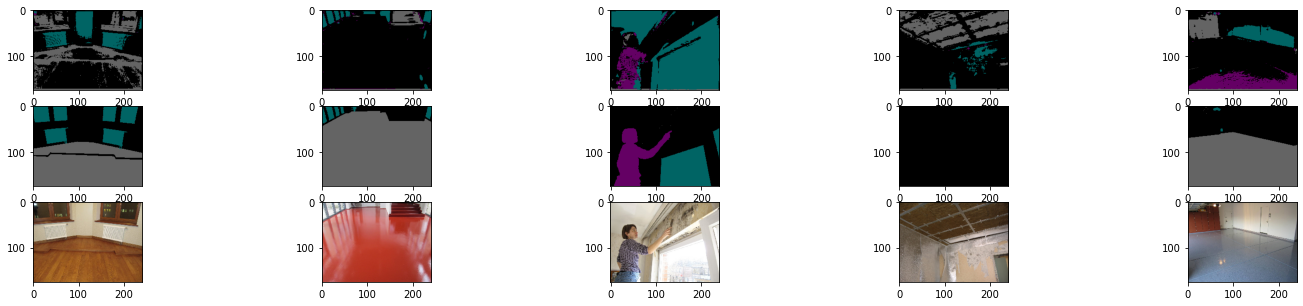

In [ ]:
processImage(modelL, 5, num_classes)

### U-net

batch_size=32

val_dice_coef: 0.7284



In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 5, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [ ]:
modelUnet = unet(num_classes, (img_width, img_height, 3)) # Создаем модель unet
history = modelUnet.fit(xTrain, yTrain, epochs=30, batch_size=32, validation_data = (xVal, yVal)) # Обучаем модель на выборке по трем классам

Epoch 1/30
29/29 [==============================] - 49s 1s/step - loss: 0.7276 - dice_coef: 0.6307 - val_loss: 3040.6831 - val_dice_coef: 0.1961
Epoch 2/30
29/29 [==============================] - 29s 1s/step - loss: 0.4551 - dice_coef: 0.7599 - val_loss: 45.6397 - val_dice_coef: 0.0831
Epoch 3/30
29/29 [==============================] - 30s 1s/step - loss: 0.4146 - dice_coef: 0.7783 - val_loss: 4.0600 - val_dice_coef: 0.5474
Epoch 4/30
29/29 [==============================] - 30s 1s/step - loss: 0.4147 - dice_coef: 0.7783 - val_loss: 1.2998 - val_dice_coef: 0.4618
Epoch 5/30
29/29 [==============================] - 30s 1s/step - loss: 0.3840 - dice_coef: 0.7950 - val_loss: 1.1362 - val_dice_coef: 0.6083
Epoch 6/30
29/29 [==============================] - 30s 1s/step - loss: 0.3893 - dice_coef: 0.7942 - val_loss: 0.8981 - val_dice_coef: 0.5911
Epoch 7/30
29/29 [==============================] - 31s 1s/step - loss: 0.3475 - dice_coef: 0.8151 - val_loss: 0.7817 - val_dice_coef: 0.6756
Ep

In [ ]:
modelUnet.save_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelUnet.h5')

#### Распознавание



In [ ]:
modelUnet = unet(num_classes, (img_width, img_height, 3)) # Создаем модель unet
modelUnet.load_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelUnet.h5')

1/1 [==============================] - 0s 20ms/step


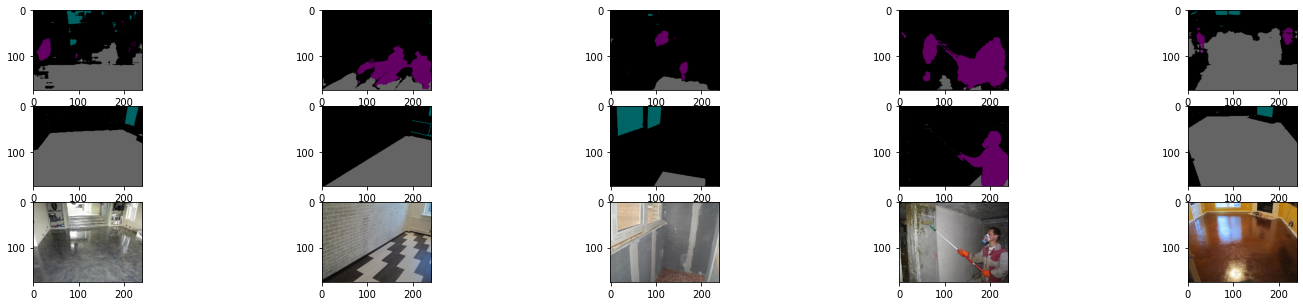

In [ ]:
processImage(modelUnet, 5, num_classes)

### Упрощённая U-net

batch_size=32

val_dice_coef: 0.6034



In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def simpleUnet(num_classes = 5, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D
    
    # UP 1
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(num_classes,(3,3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                            # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

In [ ]:
modelS = simpleUnet(num_classes, (img_width, img_height, 3))                                                              # Создаем модель simpleUnet
history = modelS.fit(xTrain, yTrain, epochs=30, batch_size=32, validation_data = (xVal, yVal)) # Обучаем модель на выборке по трем классам

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
29/29 [==============================] - 13s 331ms/step - loss: 0.9380 - dice_coef: 0.5041 - val_loss: 1.4087 - val_dice_coef: 0.2802
Epoch 2/30
29/29 [==============================] - 8s 287ms/step - loss: 0.5927 - dice_coef: 0.6636 - val_loss: 1.4568 - val_dice_coef: 0.2711
Epoch 3/30
29/29 [==============================] - 8s 288ms/step - loss: 0.5500 - dice_coef: 0.6882 - val_loss: 1.0052 - val_dice_coef: 0.4042
Epoch 4/30
29/29 [==============================] - 8s 289ms/step - loss: 0.5362 - dice_coef: 0.6995 - val_loss: 0.9695 - val_dice_coef: 0.4859
Epoch 5/30
29/29 [==============================] - 8s 289ms/step - loss: 0.5193 - dice_coef: 0.7130 - val_loss: 0.9380 - val_dice_coef: 0.5344
Epoch 6/30
29/29 [==============================] - 8s 290ms/step - loss: 0.5039 - dice_coef: 0.7231 - val_loss: 0.7707 - val_dice_coef: 0.5810
Epoch 7/30
29/29 [==============================] - 8s 290ms/step - loss: 0.4847 - dice_coef: 0.7284 - val_loss: 0.7631 - val_dice_coef

In [ ]:
modelS.save_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelS.h5')

#### Распознавание

In [ ]:
modelS = simpleUnet(num_classes, (img_width, img_height, 3))    
modelS.load_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelS.h5')

1/1 [==============================] - 0s 18ms/step


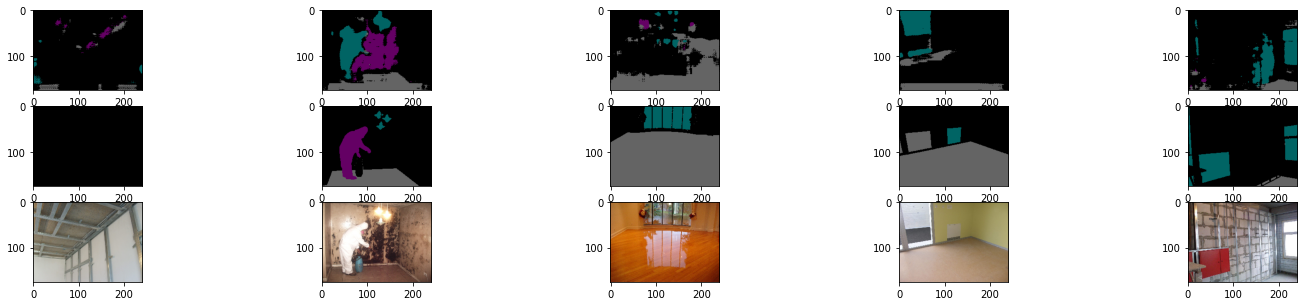

In [ ]:
processImage(modelS, 5, num_classes)

### Расширенная U-net

batch_size=16

val_dice_coef: 0.7734


In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask(num_classes = 5, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

In [ ]:
modelM3 = unetWithMask(num_classes, (img_width, img_height,3))
history = modelM3.fit(xTrain, yTrain, epochs=30, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/30
57/57 [==============================] - 42s 688ms/step - loss: 0.8258 - dice_coef: 0.5790 - val_loss: 12.0058 - val_dice_coef: 0.5418
Epoch 2/30
57/57 [==============================] - 39s 684ms/step - loss: 0.5166 - dice_coef: 0.7146 - val_loss: 40.8342 - val_dice_coef: 0.3799
Epoch 3/30
57/57 [==============================] - 39s 687ms/step - loss: 0.4464 - dice_coef: 0.7618 - val_loss: 1.6929 - val_dice_coef: 0.5647
Epoch 4/30
57/57 [==============================] - 39s 688ms/step - loss: 0.4004 - dice_coef: 0.7843 - val_loss: 0.8959 - val_dice_coef: 0.6073
Epoch 5/30
57/57 [==============================] - 40s 699ms/step - loss: 0.3806 - dice_coef: 0.7980 - val_loss: 0.9032 - val_dice_coef: 0.6762
Epoch 6/30
57/57 [==============================] - 40s 706ms/step - loss: 0.3597 - dice_coef: 0.8089 - val_loss: 0.7483 - val_dice_coef: 0.7053
Epoch 7/30
57/57 [==============================] - 40s 702ms/step - loss: 0.3355 - dice_coef: 0.8211 - val_loss: 0.8662 - val_d

In [ ]:
modelM3.save_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelM3.h5')

#### Распознавание



In [ ]:
modelM3 = unetWithMask(num_classes, (img_width, img_height,3))
modelM3.load_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelM3.h5')

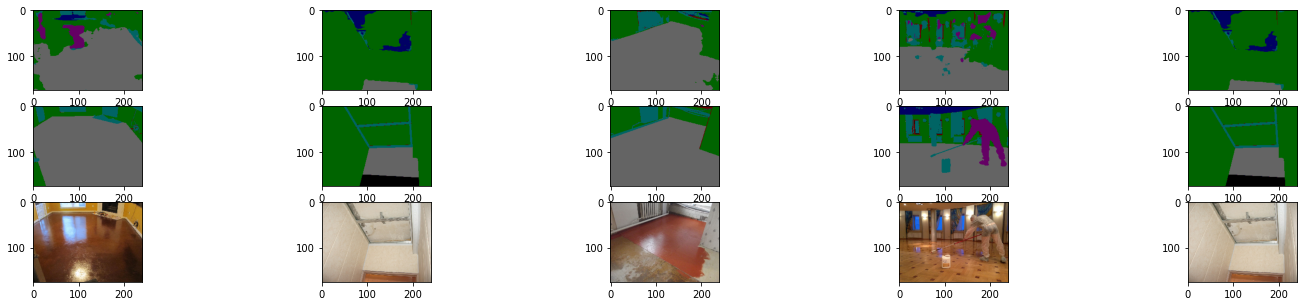

In [ ]:
processImage(modelM3, 5, num_classes)

### U-Net simple training

batch_size=32

val_iou_score: 0.4259

Предвартельно созданы наборы данных с размером картинок (256, 256, 3) - для совпадения с размером входного слоя трансформера.

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 1.8 MB/s 


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-23rr_1iy
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-23rr_1iy
  Running command git submodule update --init --recursive -q


In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# preprocess input
xTrain = preprocess_input(xTrain)
xVal = preprocess_input(xVal)

# define model

model_T = Unet(BACKBONE, encoder_weights='imagenet', classes=num_classes, input_shape=(256, 256, 3))
model_T.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [ ]:
print(xTrain.shape)

(900, 256, 256, 3)


In [ ]:
model_T.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_136 (ZeroPaddin  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                           

In [ ]:
# fit model
model_T.fit(
    x=xTrain,
    y=yTrain,
    batch_size=32,
    epochs=100,
    validation_data=(xVal, yVal))

Epoch 1/100
29/29 [==============================] - 24s 618ms/step - loss: 1.2630 - iou_score: 0.2129 - val_loss: 2.6206 - val_iou_score: 0.1279
Epoch 2/100
29/29 [==============================] - 14s 470ms/step - loss: 0.8898 - iou_score: 0.3051 - val_loss: 1.7984 - val_iou_score: 0.1927
Epoch 3/100
29/29 [==============================] - 14s 473ms/step - loss: 0.7605 - iou_score: 0.3608 - val_loss: 1.3986 - val_iou_score: 0.1522
Epoch 4/100
29/29 [==============================] - 14s 477ms/step - loss: 0.6725 - iou_score: 0.4254 - val_loss: 2.1682 - val_iou_score: 0.1002
Epoch 5/100
29/29 [==============================] - 14s 482ms/step - loss: 0.6562 - iou_score: 0.4534 - val_loss: 1.3518 - val_iou_score: 0.2430
Epoch 6/100
29/29 [==============================] - 14s 486ms/step - loss: 0.5873 - iou_score: 0.5022 - val_loss: 1.1113 - val_iou_score: 0.3114
Epoch 7/100
29/29 [==============================] - 14s 487ms/step - loss: 0.5597 - iou_score: 0.5258 - val_loss: 1.0557 - 

In [ ]:
model_T.save_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/model_unet_fine_tuning.h5')

#### Распознавание

In [ ]:
def model_simple_training(num_classes, input_shape):
  model_T = Unet(BACKBONE, encoder_weights='imagenet', classes=num_classes, input_shape=(256, 256, 3))
  model_T.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
  return model_T

In [ ]:
model_T = model_simple_training(num_classes, (img_width, img_height,3))
model_T.load_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/model_unet_fine_tuning.h5')

1/1 [==============================] - 0s 20ms/step


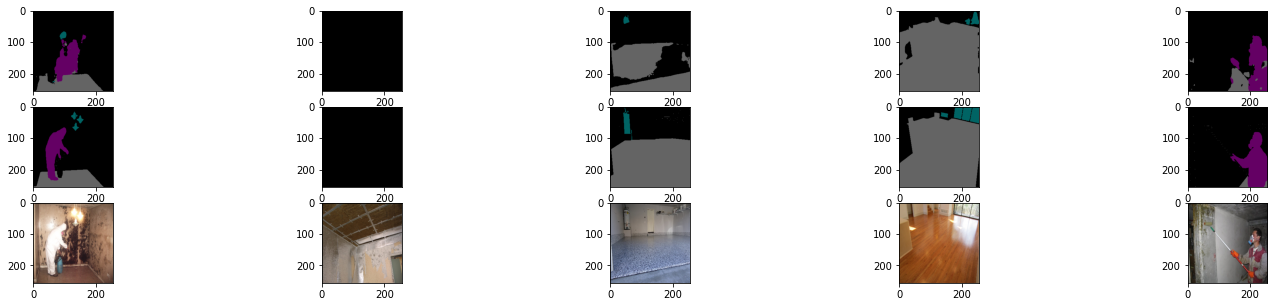

In [ ]:
processImage(model_T, 5, num_classes)

### U-Net fine tuning

batch_size=16

dice_coef: 0.8977

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

In [ ]:
model_freeze = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=num_classes,input_shape=(256, 256, 3))
# Компилируем модель 
model_freeze.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])

In [ ]:
model_freeze.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_272 (ZeroPaddin  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                           

In [ ]:
# pretrain model decoder
# model.fit(x, y, epochs=2)
history = model_freeze.fit(xTrain, yTrain, epochs=2, batch_size=16, validation_data = (xVal, yVal))
# release all layers for training
set_trainable(model_freeze) # set all layers trainable and recompile model



Epoch 1/2
57/57 [==============================] - 17s 224ms/step - loss: 0.5335 - dice_coef: 0.5850 - val_loss: 3.5914 - val_dice_coef: 0.5196
Epoch 2/2
57/57 [==============================] - 12s 212ms/step - loss: 0.2689 - dice_coef: 0.7144 - val_loss: 0.6381 - val_dice_coef: 0.6566


AttributeError: ignored

In [ ]:
# continue training
model_freeze.fit(xTrain, yTrain, epochs=100)

Epoch 1/100
29/29 [==============================] - 12s 394ms/step - loss: 0.1968 - dice_coef: 0.7505
Epoch 2/100
29/29 [==============================] - 11s 395ms/step - loss: 0.1784 - dice_coef: 0.7663
Epoch 3/100
29/29 [==============================] - 12s 397ms/step - loss: 0.1669 - dice_coef: 0.7801
Epoch 4/100
29/29 [==============================] - 12s 399ms/step - loss: 0.1480 - dice_coef: 0.7949
Epoch 5/100
29/29 [==============================] - 12s 400ms/step - loss: 0.1324 - dice_coef: 0.8051
Epoch 6/100
29/29 [==============================] - 12s 401ms/step - loss: 0.1343 - dice_coef: 0.8098
Epoch 7/100
29/29 [==============================] - 12s 401ms/step - loss: 0.1250 - dice_coef: 0.8155
Epoch 8/100
29/29 [==============================] - 12s 403ms/step - loss: 0.1153 - dice_coef: 0.8229
Epoch 9/100
29/29 [==============================] - 12s 403ms/step - loss: 0.1173 - dice_coef: 0.8265
Epoch 10/100
29/29 [==============================] - 12s 404ms/step - lo

In [ ]:
model_freeze.save_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/model_unet_freeze.h5')

#### Распознование

In [ ]:
def model_unet_freeze(num_classes, input_shape):
  model_freeze = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=num_classes,input_shape=(256, 256, 3))
  # Компилируем модель 
  model_freeze.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
  return model_freeze 

In [ ]:
model_freeze = model_unet_freeze(num_classes, (img_width, img_height,3))
model_freeze.load_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/model_unet_freeze.h5')

1/1 [==============================] - 0s 20ms/step


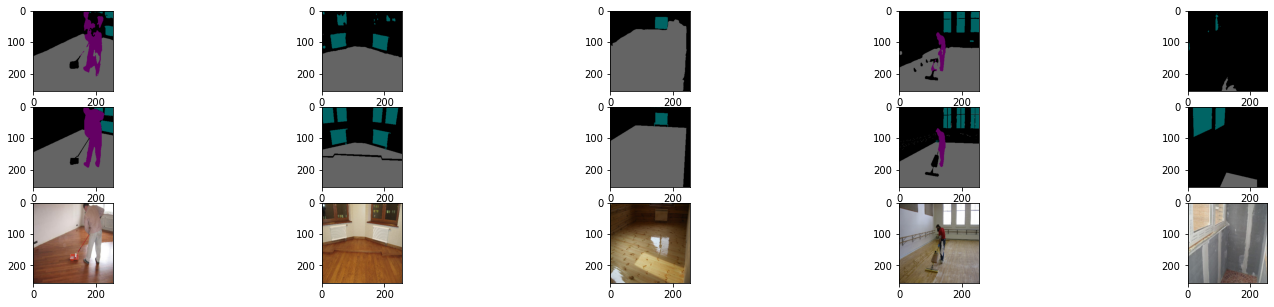

In [ ]:
processImage(model_freeze, 5, num_classes)

## Разные batch_size упрощённая U-net

### batch_size=8

val_dice_coef: 0.6366

In [ ]:
modelS_bs_8 = simpleUnet(num_classes, (img_width, img_height, 3))                                                              # Создаем модель simpleUnet
history = modelS_bs_8.fit(xTrain, yTrain, epochs=30, batch_size=8, validation_data = (xVal, yVal))

Epoch 1/30
113/113 [==============================] - 12s 86ms/step - loss: 0.6809 - dice_coef: 0.6212 - val_loss: 1.1822 - val_dice_coef: 0.3982
Epoch 2/30
113/113 [==============================] - 9s 78ms/step - loss: 0.5670 - dice_coef: 0.6822 - val_loss: 0.8454 - val_dice_coef: 0.5638
Epoch 3/30
113/113 [==============================] - 9s 79ms/step - loss: 0.5377 - dice_coef: 0.7013 - val_loss: 0.7368 - val_dice_coef: 0.5997
Epoch 4/30
113/113 [==============================] - 9s 78ms/step - loss: 0.5245 - dice_coef: 0.7057 - val_loss: 0.9180 - val_dice_coef: 0.5938
Epoch 5/30
113/113 [==============================] - 9s 78ms/step - loss: 0.5124 - dice_coef: 0.7146 - val_loss: 0.7278 - val_dice_coef: 0.6383
Epoch 6/30
113/113 [==============================] - 9s 78ms/step - loss: 0.4916 - dice_coef: 0.7257 - val_loss: 0.8829 - val_dice_coef: 0.5341
Epoch 7/30
113/113 [==============================] - 9s 77ms/step - loss: 0.4784 - dice_coef: 0.7341 - val_loss: 0.6744 - val_di

In [ ]:
modelS_bs_8.save_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelS_bs_8.h5')

In [ ]:
modelS_bs_8 = simpleUnet(num_classes, (img_width, img_height, 3))    
modelS_bs_8.load_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelS_bs_8.h5')

1/1 [==============================] - 0s 16ms/step


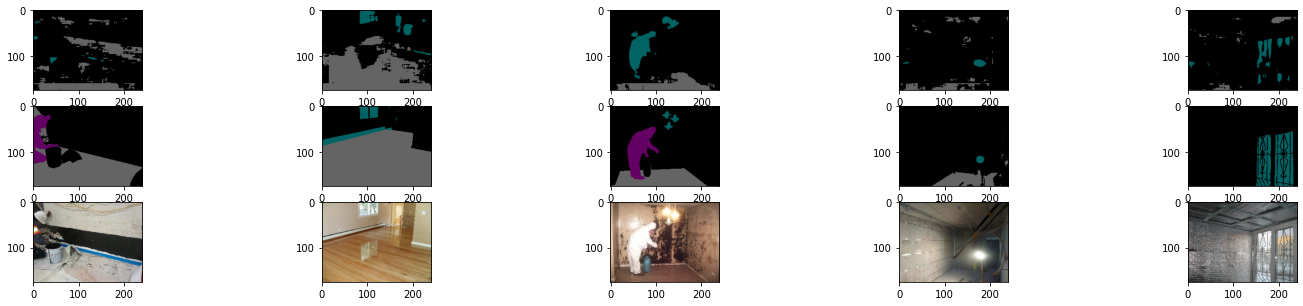

In [ ]:
processImage(modelS_bs_8, 5, num_classes)

### batch_size=128

val_dice_coef: 0.5648

In [ ]:
modelS_bs_128 = simpleUnet(num_classes, (img_width, img_height, 3))                                                              # Создаем модель simpleUnet
history = modelS_bs_128.fit(xTrain, yTrain, epochs=30, batch_size=128, validation_data = (xVal, yVal))

Epoch 1/30
8/8 [==============================] - 19s 1s/step - loss: 1.1728 - dice_coef: 0.3922 - val_loss: 1.7193 - val_dice_coef: 0.2091
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 0.7015 - dice_coef: 0.5933 - val_loss: 1.7490 - val_dice_coef: 0.2674
Epoch 3/30
8/8 [==============================] - 9s 1s/step - loss: 0.6302 - dice_coef: 0.6319 - val_loss: 1.6025 - val_dice_coef: 0.2877
Epoch 4/30
8/8 [==============================] - 9s 1s/step - loss: 0.6018 - dice_coef: 0.6552 - val_loss: 1.4326 - val_dice_coef: 0.2678
Epoch 5/30
8/8 [==============================] - 9s 1s/step - loss: 0.5695 - dice_coef: 0.6820 - val_loss: 1.4283 - val_dice_coef: 0.2661
Epoch 6/30
8/8 [==============================] - 9s 1s/step - loss: 0.5779 - dice_coef: 0.6979 - val_loss: 1.3979 - val_dice_coef: 0.2710
Epoch 7/30
8/8 [==============================] - 9s 1s/step - loss: 0.5581 - dice_coef: 0.6952 - val_loss: 1.1737 - val_dice_coef: 0.3315
Epoch 8/30
8/8 [==========

In [ ]:
modelS_bs_128.save_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelS_bs_128.h5')

In [ ]:
modelS_bs_128 = simpleUnet(num_classes, (img_width, img_height, 3))    
modelS_bs_128.load_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/modelS_bs_128.h5')

1/1 [==============================] - 0s 17ms/step


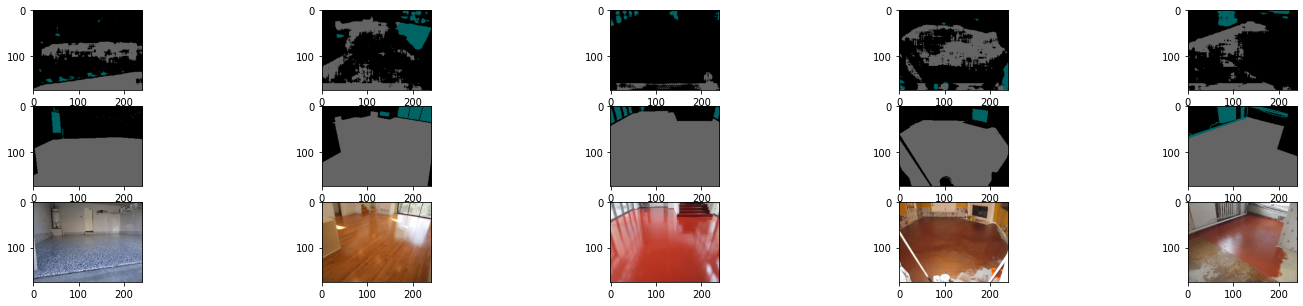

In [ ]:
processImage(modelS_bs_8, 5, num_classes)

## Разные функции активации


### Функции и переменные

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
activation0 = Activation('elu')(x) 
activation1 = Activation('tanh')(x)
activation2 = Activation('linear')(x)
activation3 = Activation('softmax')(x)



def simpleUnetActivations(num_classes = 5, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = activation                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = activation                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = activation                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = activation                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D
    
    # UP 1
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = activation                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = activation                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = activation                                              # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = activation                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = activation                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = activation                                              # Добавляем слой Activation

    x = Conv2D(num_classes,(3,3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                            # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

### Упрощённая U-net , activation = 'elu'

val_dice_coef: 0.6460

In [ ]:
activation = activation0
modelS_activation0 = simpleUnet(num_classes, (img_width, img_height, 3))                                                              # Создаем модель simpleUnet
history = modelS_activation0.fit(xTrain, yTrain, epochs=30, batch_size=32, validation_data = (xVal, yVal))

Epoch 1/30
29/29 [==============================] - 10s 311ms/step - loss: 0.8589 - dice_coef: 0.5396 - val_loss: 2.3269 - val_dice_coef: 0.1973
Epoch 2/30
29/29 [==============================] - 9s 305ms/step - loss: 0.5979 - dice_coef: 0.6665 - val_loss: 1.5566 - val_dice_coef: 0.2603
Epoch 3/30
29/29 [==============================] - 9s 308ms/step - loss: 0.5783 - dice_coef: 0.6732 - val_loss: 1.0980 - val_dice_coef: 0.3735
Epoch 4/30
29/29 [==============================] - 9s 311ms/step - loss: 0.5496 - dice_coef: 0.6985 - val_loss: 1.0597 - val_dice_coef: 0.4107
Epoch 5/30
29/29 [==============================] - 9s 309ms/step - loss: 0.5328 - dice_coef: 0.7032 - val_loss: 0.9040 - val_dice_coef: 0.5028
Epoch 6/30
29/29 [==============================] - 9s 306ms/step - loss: 0.5336 - dice_coef: 0.6990 - val_loss: 0.9996 - val_dice_coef: 0.4833
Epoch 7/30
29/29 [==============================] - 9s 304ms/step - loss: 0.5140 - dice_coef: 0.7137 - val_loss: 0.8115 - val_dice_coef

### Упрощённая U-net , activation = 'tanh'

val_dice_coef: 0.6730

In [ ]:
activation = activation1
modelS_activation1 = simpleUnet(num_classes, (img_width, img_height, 3))                                                              # Создаем модель simpleUnet
history = modelS_activation1.fit(xTrain, yTrain, epochs=30, batch_size=32, validation_data = (xVal, yVal))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
29/29 [==============================] - 10s 313ms/step - loss: 1.0202 - dice_coef: 0.4704 - val_loss: 1.2352 - val_dice_coef: 0.3561
Epoch 2/30
29/29 [==============================] - 9s 306ms/step - loss: 0.6181 - dice_coef: 0.6547 - val_loss: 1.3183 - val_dice_coef: 0.2820
Epoch 3/30
29/29 [==============================] - 9s 310ms/step - loss: 0.5811 - dice_coef: 0.6780 - val_loss: 1.1254 - val_dice_coef: 0.3597
Epoch 4/30
29/29 [==============================] - 9s 309ms/step - loss: 0.5603 - dice_coef: 0.6884 - val_loss: 1.0368 - val_dice_coef: 0.4057
Epoch 5/30
29/29 [==============================] - 9s 306ms/step - loss: 0.5437 - dice_coef: 0.6982 - val_loss: 1.0286 - val_dice_coef: 0.5219
Epoch 6/30
29/29 [==============================] - 9s 304ms/step - loss: 0.5238 - dice_coef: 0.7072 - val_loss: 1.0191 - val_dice_coef: 0.5268
Epoch 7/30
29/29 [==============================] - 9s 303ms/step - loss: 0.5096 - dice_coef: 0.7160 - val_loss: 1.0710 - val_dice_coef

### Упрощённая U-net , activation = 'linear'

val_dice_coef: 0.6732

In [ ]:
activation = activation2
modelS_activation2 = simpleUnet(num_classes, (img_width, img_height, 3))                                                              # Создаем модель simpleUnet
history = modelS_activation2.fit(xTrain, yTrain, epochs=30, batch_size=32, validation_data = (xVal, yVal))

Epoch 1/30
29/29 [==============================] - 10s 317ms/step - loss: 0.8455 - dice_coef: 0.5453 - val_loss: 1.5553 - val_dice_coef: 0.2354
Epoch 2/30
29/29 [==============================] - 9s 311ms/step - loss: 0.5931 - dice_coef: 0.6682 - val_loss: 1.3333 - val_dice_coef: 0.2874
Epoch 3/30
29/29 [==============================] - 9s 311ms/step - loss: 0.5680 - dice_coef: 0.6832 - val_loss: 1.0855 - val_dice_coef: 0.3925
Epoch 4/30
29/29 [==============================] - 9s 309ms/step - loss: 0.5459 - dice_coef: 0.6970 - val_loss: 0.8864 - val_dice_coef: 0.4623
Epoch 5/30
29/29 [==============================] - 9s 304ms/step - loss: 0.5324 - dice_coef: 0.6970 - val_loss: 0.8653 - val_dice_coef: 0.4999
Epoch 6/30
29/29 [==============================] - 9s 301ms/step - loss: 0.5244 - dice_coef: 0.7062 - val_loss: 1.0769 - val_dice_coef: 0.5163
Epoch 7/30
29/29 [==============================] - 9s 301ms/step - loss: 0.5036 - dice_coef: 0.7201 - val_loss: 0.8964 - val_dice_coef

### Упрощённая U-net , activation = 'softmax'

In [ ]:
activation = activation3
modelS_activation3 = simpleUnet(num_classes, (img_width, img_height, 3))                                                              # Создаем модель simpleUnet
history = modelS_activation3.fit(xTrain, yTrain, epochs=30, batch_size=32, validation_data = (xVal, yVal))

Epoch 1/30
29/29 [==============================] - 10s 316ms/step - loss: 0.8786 - dice_coef: 0.5335 - val_loss: 5.9187 - val_dice_coef: 0.0865
Epoch 2/30
29/29 [==============================] - 9s 310ms/step - loss: 0.6130 - dice_coef: 0.6628 - val_loss: 2.0397 - val_dice_coef: 0.1981
Epoch 3/30
29/29 [==============================] - 9s 311ms/step - loss: 0.5780 - dice_coef: 0.6774 - val_loss: 1.0115 - val_dice_coef: 0.3901
Epoch 4/30
29/29 [==============================] - 9s 308ms/step - loss: 0.5440 - dice_coef: 0.7000 - val_loss: 0.8819 - val_dice_coef: 0.4918
Epoch 5/30
29/29 [==============================] - 9s 305ms/step - loss: 0.5256 - dice_coef: 0.7029 - val_loss: 0.9053 - val_dice_coef: 0.5086
Epoch 6/30
29/29 [==============================] - 9s 305ms/step - loss: 0.5134 - dice_coef: 0.7103 - val_loss: 0.7921 - val_dice_coef: 0.5560
Epoch 7/30
29/29 [==============================] - 9s 303ms/step - loss: 0.5024 - dice_coef: 0.7178 - val_loss: 0.8244 - val_dice_coef

# Выводы

  Наилучший результат показала модель U-Net, предобученная на датасете "Imagenet". Результат после дообучения **dice_coef: 0.8977**, что превысло результаты других моделей как минимум на 12%. Для обучения данной сети предварительно был запущен код загрузки наборов данных с размером 256 х 256 х 3. Далее код обновлен под размер данных 176 х 240 х 3. Вцелом хороший результат дала расширенная U-Net и чуть послабее модель U-Net. В аутсайдерах линейная модель, даже на 100 эпохах результат не улучшился. Худший показатель получен у модели U-Net simple training, где была изменена метрика **dice_coef** и **loss='categorical_crossentropy'** на loss=bce_jaccard_loss, metrics=[iou_score]. 

  Увеличение batch_size до 128 скорее ухудшило качество работы сети. А уменьшение batch_size до 8 дало незначительное улучшение качества сегментации. 

  Лучшие результаты у функций активации "linear" и "tanh". Как ни странно "softmax" прекрасно отработал.

    


